## Trigger Word Detection

<img src="images/sound.png" style="width:1000px;height:150px;">

## Table of Contents

- [Packages](#0)
- [1 - Data synthesis: Creating a Speech Dataset](#1)
    - [1.1 - Listening to the Data](#1-1)
    - [1.2 - From Audio Recordings to Spectrograms](#1-2)
    - [1.3 - Generating a Single Training Example](#1-3)
        - [Is_overlapping](#ex-1)
        - [Insert_audio_clip](#ex-2)
        - [Insert_ones](#ex-3)
        - [Create_training_example](#ex-4)
    - [1.4 - Full Training Set](#1-4)
    - [1.5 - Development Set](#1-5)
- [2 - The Model](#2)
    - [2.1 - Build the Model](#2-1)
        - [Modelf](#ex-5)
    - [2.2 - Fit the Model](#2-2)
    - [2.3 - Test the Model](#2-3)
- [3 - Making Predictions](#3)
    - [3.1 - Test on Dev Examples](#3-1)
- [4 - Try Your Own Example!](#4)

<a name='0'></a>
## Packages

In [1]:
import numpy as np
from pydub import AudioSegment
import random
import sys
import io
import os
import glob
import IPython
from td_utils import *
%matplotlib inline

<a name='1'></a>
## 1 - Data synthesis: Creating a Speech Dataset 

<a name='1-1'></a>
### 1.1 - Listening to the Data   

In [ ]:
IPython.display.Audio("./raw_data/activates/1.wav")

In [ ]:
IPython.display.Audio("./raw_data/negatives/4.wav")

In [ ]:
IPython.display.Audio("./raw_data/backgrounds/1.wav")

We will use these three types of recordings (positives/negatives/backgrounds) to create a labeled dataset.

<a name='1-2'></a>
### 1.2 - From Audio Recordings to Spectrograms

What really is an audio recording? 
* A microphone records little variations in air pressure over time, and it is these little variations in air pressure that your ear also perceives as sound. 
* You can think of an audio recording as a long list of numbers measuring the little air pressure changes detected by the microphone. 
* We will use audio sampled at 44100 Hz (or 44100 Hertz). 
    * This means the microphone gives us 44,100 numbers per second. 
    * Thus, a 10 second audio clip is represented by 441,000 numbers (= $10 \times 44,100$). 

#### Spectrogram
* It is quite difficult to figure out from this "raw" representation of audio whether the word "activate" was said. 
* In  order to help your sequence model more easily learn to detect trigger words, we will compute a *spectrogram* of the audio. 
* The spectrogram tells us how much different frequencies are present in an audio clip at any moment in time. 
* A spectrogram is computed by sliding a window over the raw audio signal, and calculating the most active frequencies in each window using a Fourier transform. t.

Let's look at an example. 

In [ ]:
IPython.display.Audio("audio_examples/example_train.wav")

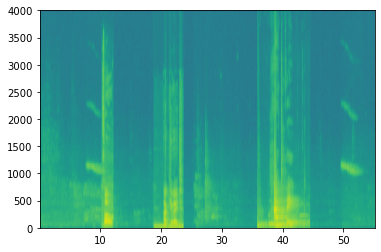

In [6]:
x = graph_spectrogram("audio_examples/example_train.wav")

The graph above represents how active each frequency is (y axis) over a number of time-steps (x axis). 

<img src="images/spectrogram.png" style="width:500px;height:200px;">
<center> **Figure 1**: Spectrogram of an audio recording </center>


* The color in the spectrogram shows the degree to which different frequencies are present (loud) in the audio at different points in time. 
* Green means a certain frequency is more active or more present in the audio clip (louder).
* Blue squares denote less active frequencies.
* The dimension of the output spectrogram depends upon the hyperparameters of the spectrogram software and the length of the input. 
* In this notebook, we will be working with 10 second audio clips as the "standard length" for our training examples. 
    * The number of timesteps of the spectrogram will be 5511. 
    * The spectrogram will be the input $x$ into the network, and so $T_x = 5511$.

In [7]:
_, data = wavfile.read("audio_examples/example_train.wav")
print("Time steps in audio recording before spectrogram", data[:,0].shape)
print("Time steps in input after spectrogram", x.shape)

Time steps in audio recording before spectrogram (441000,)
Time steps in input after spectrogram (101, 5511)


In [8]:
Tx = 5511 # The number of time steps input to the model from the spectrogram
n_freq = 101 # Number of frequencies input to the model at each time step of the spectrogram

#### Dividing into time-intervals
We may divide a 10 second interval of time with different units (steps).
* Raw audio divides 10 seconds into 441,000 units.
* A spectrogram divides 10 seconds into 5,511 units.
    * $T_x = 5511$
* You will use a Python module `pydub` to synthesize audio, and it divides 10 seconds into 10,000 units.
* The output of our model will divide 10 seconds into 1,375 units.
    * $T_y = 1375$
    * For each of the 1375 time steps, the model predicts whether someone recently finished saying the trigger word "activate". 
* All of these are hyperparameters and can be changed (except the 441000, which is a function of the microphone). 
* We have chosen values that are within the standard range used for speech systems.

In [9]:
Ty = 1375 # The number of time steps in the output of our model

<a name='1-3'></a>
### 1.3 - Generating a Single Training Example

#### Benefits of synthesizing data
Because speech data is hard to acquire and label, we will synthesize your training data using the audio clips of activates, negatives, and backgrounds. 
* It is quite slow to record lots of 10 second audio clips with random "activates" in it. 
* Instead, it is easier to record lots of positives and negative words, and record background noise separately (or download background noise from free online sources).  

#### Pydub
* Pydub converts raw audio files into lists of Pydub data structures.
* Pydub uses 1ms as the discretization interval (1 ms is 1 millisecond = 1/1000 seconds).
    * This is why a 10 second clip is always represented using 10,000 steps. 

In [10]:
# Loading audio segments using pydub 
activates, negatives, backgrounds = load_raw_audio('./raw_data/')

print("background len should be 10,000, since it is a 10 sec clip\n" + str(len(backgrounds[0])),"\n")
print("activate[0] len may be around 1000, since an `activate` audio clip is usually around 1 second (but varies a lot) \n" + str(len(activates[0])),"\n")
print("activate[1] len: different `activate` clips can have different lengths\n" + str(len(activates[1])),"\n")

background len should be 10,000, since it is a 10 sec clip
10000 

activate[0] len may be around 1000, since an `activate` audio clip is usually around 1 second (but varies a lot) 
916 

activate[1] len: different `activate` clips can have different lengths
1579 



#### Overlaying positive/negative 'word' audio clips on top of the background audio

* Given a 10 second background clip and a short audio clip containing a positive or negative word, we need to be able to "add" the word audio clip on top of the background audio.
* We will be inserting multiple clips of positive/negative words into the background, and we don't want to insert an "activate" or a random word somewhere that overlaps with another clip you had previously added. 
    * To ensure that the 'word' audio segments do not overlap when inserted, we will keep track of the times of previously inserted audio clips. 
* To be clear, when we insert a 1 second "activate" onto a 10 second clip of cafe noise, **we do not end up with an 11 sec clip.** 
    * The resulting audio clip is still 10 seconds long.

#### Visualizing the labels
* Here's a figure illustrating the labels $y^{\langle t \rangle}$ in a clip.
    * We have inserted "activate", "innocent", "activate", "baby." 
    * Note that the positive labels "1" are associated only with the positive words. 

<img src="images/label_diagram.png" style="width:500px;height:200px;">
<center> **Figure 2** </center>



#### Get a random time segment

* The function `get_random_time_segment(segment_ms)` returns a random time segment onto which we can insert an audio clip of duration `segment_ms`. 
* Please read through the code to make sure you understand what it is doing. 

In [11]:
def get_random_time_segment(segment_ms):
    """
    Gets a random time segment of duration segment_ms in a 10,000 ms audio clip.
    
    Arguments:
    segment_ms -- the duration of the audio clip in ms ("ms" stands for "milliseconds")
    
    Returns:
    segment_time -- a tuple of (segment_start, segment_end) in ms
    """
    
    segment_start = np.random.randint(low=0, high=10000-segment_ms)   # segment doesn't run past the 10sec background 
    segment_end = segment_start + segment_ms - 1
    
    return (segment_start, segment_end)

#### Check if audio clips are overlapping

* Suppose we have inserted audio clips at segments (1000,1800) and (3400,4500).
    * The first segment starts at step 1000 and ends at step 1800. 
    * The second segment starts at 3400 and ends at 4500.
* If we are considering whether to insert a new audio clip at (3000,3600) does this overlap with one of the previously inserted segments? 
    * In this case, (3000,3600) and (3400,4500) overlap, so we should decide against inserting a clip here.
* For the purpose of this function, define (100,200) and (200,250) to be overlapping, since they overlap at timestep 200. 
* (100,199) and (200,250) are non-overlapping. 

<a name='ex-1'></a>
### Is_overlapping

In [12]:
def is_overlapping(segment_time, previous_segments):
    """
    Checks if the time of a segment overlaps with the times of existing segments.
    
    Arguments:
    segment_time -- a tuple of (segment_start, segment_end) for the new segment
    previous_segments -- a list of tuples of (segment_start, segment_end) for the existing segments
    
    Returns:
    True if the time segment overlaps with any of the existing segments, False otherwise
    """
    
    segment_start, segment_end = segment_time
    
    # Initializing overlap as a "False" flag
    overlap = False
    
    # Compare start/end times and set the flag to True if there is an overlap
    for previous_start, previous_end in previous_segments:
        if segment_start <= previous_end and segment_end >= previous_start:
            overlap = True
            break
    return overlap

In [14]:
overlap1 = is_overlapping((950, 1430), [(2000, 2550), (260, 949)])
overlap2 = is_overlapping((2305, 2950), [(824, 1532), (1900, 2305), (3424, 3656)])
print("Overlap 1 = ", overlap1)
print("Overlap 2 = ", overlap2)

Overlap 1 =  False
Overlap 2 =  True


**Expected Output**:

<table>
    <tr>
        <td>
            **Overlap 1**
        </td>
        <td>
           False
        </td>
    </tr>
    <tr>
        <td>
            **Overlap 2**
        </td>
        <td>
           True
        </td>
    </tr>
</table>

#### Insert audio clip

* Let's use the previous helper functions to insert a new audio clip onto the 10 second background at a random time.
* We will ensure that any newly inserted segment doesn't overlap with previously inserted segments. 

<a name='ex-2'></a>
### Insert_audio_clip

In [15]:
def insert_audio_clip(background, audio_clip, previous_segments):
    """
    Insert a new audio segment over the background noise at a random time step, ensuring that the 
    audio segment does not overlap with existing segments.
    
    Arguments:
    background -- a 10 second background audio recording.  
    audio_clip -- the audio clip to be inserted/overlaid. 
    previous_segments -- times where audio segments have already been placed
    
    Returns:
    new_background -- the updated background audio
    """
    
    segment_ms = len(audio_clip)
    
    segment_time = get_random_time_segment(segment_ms)
    
    # if the new segment_time overlaps with one of the previous_segments. If so, keep 
    # picking new segment_time at random until it doesn't overlap. To avoid an endless loop
    # we retry 5 times
    retry = 5
    while is_overlapping(segment_time, previous_segments) and retry >= 0:
        segment_time = get_random_time_segment(segment_ms)
        retry = retry - 1

    # if last try is not overlaping, insert it to the background
    if not is_overlapping(segment_time, previous_segments):
        previous_segments.append(segment_time)
        # Superposing audio segment and background
        new_background = background.overlay(audio_clip, position = segment_time[0])
        print(segment_time)
    else:
        print("Timeouted")
        new_background = background
        segment_time = (10000, 10000)
    
    return new_background, segment_time

In [ ]:
np.random.seed(5)
audio_clip, segment_time = insert_audio_clip(backgrounds[0], activates[0], [(3790, 4400)])
audio_clip.export("insert_test.wav", format="wav")
print("Segment Time: ", segment_time)
IPython.display.Audio("insert_test.wav")

In [ ]:
# Expected audio
IPython.display.Audio("audio_examples/insert_reference.wav")

#### Inserting ones for the labels of the positive target

* Implementing code to update the labels $y^{\langle t \rangle}$, assuming we just inserted an "activate" audio clip.
* In the code below, `y` is a `(1,1375)` dimensional vector, since $T_y = 1375$. 
* If the "activate" audio clip ends at time step $t$, then set $y^{\langle t+1 \rangle} = 1$ and also set the next 49 additional consecutive values to 1.
    * Notice that if the target word appears near the end of the entire audio clip, there may not be 50 additional time steps to set to 1.
    * Make sure we don't run off the end of the array and try to update `y[0][1375]`, since the valid indices are `y[0][0]` through `y[0][1374]` because $T_y = 1375$. 
    * So if "activate" ends at step 1370, we would get only set `y[0][1371] = y[0][1372] = y[0][1373] = y[0][1374] = 1`

<a name='ex-3'></a>
### Insert_ones 
* If a segment ends at `segment_end_ms` (using a 10000 step discretization),
    * To convert it to the indexing for the outputs $y$ (using a $1375$ step discretization), we will use this formula:  
```
    segment_end_y = int(segment_end_ms * Ty / 10000.0)
```

In [19]:
def insert_ones(y, segment_end_ms):
    """
    Update the label vector y. The labels of the 50 output steps strictly after the end of the segment 
    should be set to 1. By strictly we mean that the label of segment_end_y should be 0 while, the
    50 following labels should be ones.
    
    
    Arguments:
    y -- numpy array of shape (1, Ty), the labels of the training example
    segment_end_ms -- the end time of the segment in ms
    
    Returns:
    y -- updated labels
    """
    _, Ty = y.shape
    
    # duration of the background (in terms of spectrogram time-steps)
    segment_end_y = int(segment_end_ms * Ty / 10000.0)
    
    if segment_end_y < Ty:
        # 1 added to the correct index in the background label (y)
        for i in range(segment_end_y+1, segment_end_y+51):
            if i < Ty:
                y[0, i] = 1   
    return y

sanity checks: 0.0 1.0 0.0


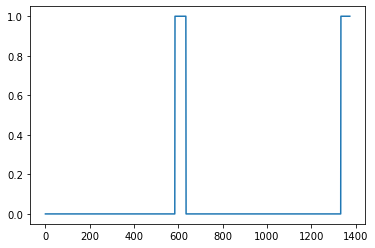

In [21]:
arr1 = insert_ones(np.zeros((1, Ty)), 9700)
plt.plot(insert_ones(arr1, 4251)[0,:])
print("sanity checks:", arr1[0][1333], arr1[0][634], arr1[0][635])

<a name='ex-4'></a>
### Create_training_example

In [22]:
def create_training_example(background, activates, negatives, Ty):
    """
    Creates a training example with a given background, activates, and negatives.
    
    Arguments:
    background -- a 10 second background audio recording
    activates -- a list of audio segments of the word "activate"
    negatives -- a list of audio segments of random words that are not "activate"
    Ty -- The number of time steps in the output

    Returns:
    x -- the spectrogram of the training example
    y -- the label at each time step of the spectrogram
    """
    
    # Make background quieter
    background = background - 20

    y = np.zeros((1, Ty))

    previous_segments = []
    
    # Select 0-4 random "activate" audio clips from the entire list of "activates" recordings
    number_of_activates = np.random.randint(0, 5)
    random_indices = np.random.randint(len(activates), size=number_of_activates)
    random_activates = [activates[i] for i in random_indices]
    
    for random_activate in random_activates:
        # Insert the audio clip on the background
        background, segment_time = insert_audio_clip(background, random_activate, previous_segments)
        # Retrieve segment_start and segment_end from segment_time
        segment_start, segment_end = segment_time
        # Insert labels in "y" at segment_end
        y = insert_ones(y, segment_end)

    # Select 0-2 random negatives audio recordings from the entire list of "negatives" recordings
    number_of_negatives = np.random.randint(0, 3)
    random_indices = np.random.randint(len(negatives), size=number_of_negatives)
    random_negatives = [negatives[i] for i in random_indices]


    for random_negative in random_negatives:
        # Insert the audio clip on the background 
        background, _ = insert_audio_clip(background, random_negative, previous_segments)
    
    # Standardize the volume of the audio clip 
    background = match_target_amplitude(background, -20.0)

    # Export new training example 
    # file_handle = background.export("train" + ".wav", format="wav")
    
    # Get and plot spectrogram of the new recording (background with superposition of positive and negatives)
    x = graph_spectrogram("train.wav")
    
    return x, y

(2885, 3793)
(1726, 2450)
(6882, 7460)


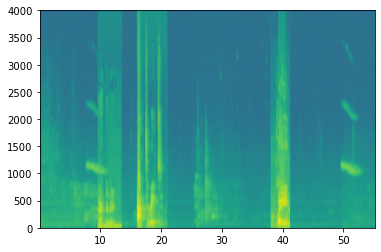

In [24]:
# Set the random seed
np.random.seed(18)
x, y = create_training_example(backgrounds[0], activates, negatives, Ty)

Now you can listen to the training example you created and compare it to the spectrogram generated above.

In [25]:
IPython.display.Audio("train.wav")

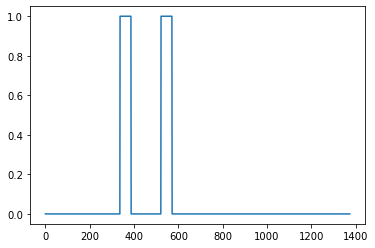

In [27]:
plt.plot(y[0])

<a name='1-4'></a>
### 1.4 - Full Training Set

0
(5817, 6484)
(9054, 9708)
(743, 1100)
(2724, 3378)
(3172, 4508)
(5426, 6093)
(2699, 5090)
(6979, 7557)
(2647, 3562)
(8049, 9789)
(4926, 5834)
Timeouted
(7289, 7829)
(1288, 1866)
(5579, 6494)
(4537, 5452)
(6835, 8171)
(2314, 2671)
(6052, 6776)
(7824, 8732)
(5096, 5750)
(1934, 2849)
(3786, 4385)
(8999, 9539)
(3454, 5032)
(2369, 2920)
(7566, 7923)
(1750, 2480)
(8759, 9489)
(3041, 4619)
(399, 1066)
(7442, 8020)
(5838, 6568)
(2884, 3551)
(1786, 2440)
(7830, 8408)
10
(5093, 5760)
(6000, 6667)
(8372, 9280)
(6266, 6625)
(7157, 7735)
(3836, 6227)
(1144, 1868)
(8661, 9328)
(2574, 3228)
(7836, 8195)
Timeouted
(2369, 3023)
(8843, 9567)
(5005, 7396)
(4395, 4752)
(8021, 8751)
(3209, 3863)
(4464, 5063)
(125, 703)
(7328, 8243)
(112, 779)
(6579, 6985)
(7100, 7506)
(8605, 9145)
(8094, 8818)
(4776, 5506)
(2991, 3715)
(1406, 2314)
(7682, 8088)
(5275, 5942)
(8012, 9752)
(3217, 4125)
(6750, 7417)
(776, 1182)
(1742, 2462)
(4311, 4851)
(3867, 4221)
20
(2713, 5104)
(7303, 9694)
(5484, 6204)
(6341, 6698)
(648

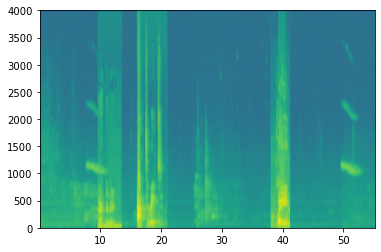

In [28]:
np.random.seed(4543)
nsamples = 32
X = []
Y = []
for i in range(0, nsamples):
    if i%10 == 0:
        print(i)
    x, y = create_training_example(backgrounds[i % 2], activates, negatives, Ty)
    X.append(x.swapaxes(0,1))
    Y.append(y.swapaxes(0,1))
X = np.array(X)
Y = np.array(Y)

<a name='1-5'></a>
### 1.5 - Development Set

In [30]:
X_dev = np.load("./XY_dev/X_dev.npy")
Y_dev = np.load("./XY_dev/Y_dev.npy")

<a name='2'></a>
## 2 - The Model

In [31]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from tensorflow.keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from tensorflow.keras.optimizers import Adam

<a name='2-1'></a>
### 2.1 - Build the Model

Our goal is to build a network that will ingest a spectrogram and output a signal when it detects the trigger word. This network will use 4 layers:
    * A convolutional layer
    * Two GRU layers
    * A dense layer. 

Here is the architecture we will use.

<img src="images/model.png" style="width:600px;height:600px;">
<center> **Figure 3** </center>

##### 1D convolutional layer
One key layer of this model is the 1D convolutional step (near the bottom of Figure 3). 
* It inputs the 5511 step spectrogram.  Each step is a vector of 101 units.
* It outputs a 1375 step output
* This output is further processed by multiple layers to get the final $T_y = 1375$ step output. 
* This 1D convolutional layer plays a role similar to the 2D convolutions you saw in Course 4, of extracting low-level features and then possibly generating an output of a smaller dimension. 
* Computationally, the 1-D conv layer also helps speed up the model because now the GRU  can process only 1375 timesteps rather than 5511 timesteps. 

##### GRU, dense and sigmoid
* The two GRU layers read the sequence of inputs from left to right.
* A dense plus sigmoid layer makes a prediction for $y^{\langle t \rangle}$. 
* Because $y$ is a binary value (0 or 1), we use a sigmoid output at the last layer to estimate the chance of the output being 1, corresponding to the user having just said "activate".

#### Unidirectional RNN
* Note that we use a **unidirectional RNN** rather than a bidirectional RNN. 
* This is really important for trigger word detection, since we want to be able to detect the trigger word almost immediately after it is said. 
* If we used a bidirectional RNN, we would have to wait for the whole 10sec of audio to be recorded before we could tell if "activate" was said in the first second of the audio clip.  

In [32]:
def modelf(input_shape):
    """
    Function creating the model's graph in Keras.
    
    Argument:
    input_shape -- shape of the model's input data (using Keras conventions)

    Returns:
    model -- Keras model instance
    """
    
    X_input = Input(shape = input_shape)
    
    # CONV layer
    X = Conv1D(196, 15, strides=4)(X_input)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = Dropout(0.8)(X)                                  

    # First GRU Layer
    X = GRU(units = 128, return_sequences=True)(X)
    X = Dropout(0.8)(X)
    X = BatchNormalization()(X)                          
    
    # Second GRU Layer
    X = GRU(units = 128, return_sequences=True)(X)
    X = Dropout(0.8)(X)       
    X = BatchNormalization()(X)
    X = Dropout(0.8)(X)
    
    #  Time-distributed dense layer
    #  with sigmoid activation 
    X = TimeDistributed(Dense(1, activation = "sigmoid"))(X)

    model = Model(inputs = X_input, outputs = X)
    
    return model  

In [34]:
model = modelf(input_shape = (Tx, n_freq))

Let's print the model summary to keep track of the shapes.

In [35]:
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 5511, 101)]       0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1375, 196)         297136    
_________________________________________________________________
batch_normalization_3 (Batch (None, 1375, 196)         784       
_________________________________________________________________
activation_1 (Activation)    (None, 1375, 196)         0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1375, 196)         0         
_________________________________________________________________
gru_2 (GRU)                  (None, 1375, 128)         125184    
_________________________________________________________________
dropout_5 (Dropout)          (None, 1375, 128)        

The output of the network is of shape (None, 1375, 1) while the input is (None, 5511, 101). The Conv1D has reduced the number of steps from 5511 to 1375. 

<a name='2-2'></a>
### 2.2 - Fit the Model

In [36]:
from tensorflow.keras.models import model_from_json

json_file = open('./models/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights('./models/model.h5')

<a name='2-2-1'></a>
#### 2.2.1 Block Training for BatchNormalization Layers

If you are going to fine-tune a pretrained model, it is important that you block the weights of all your batchnormalization layers. If you are going to train a new model from scratch, skip the next cell. 

In [37]:
model.layers[2].trainable = False
model.layers[7].trainable = False
model.layers[10].trainable = False

We can train the model further, using the Adam optimizer and binary cross entropy loss, as follows. This will run quickly because we are training just for two epochs and with a small training set of 32 examples. 

In [38]:
opt = Adam(lr=1e-6, beta_1=0.9, beta_2=0.999)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])

In [39]:
model.fit(X, Y, batch_size = 16, epochs=1)

2/2 [==============================] - 3s 1s/step - loss: 0.4367 - accuracy: 0.8764


<a name='2-3'></a>
### 2.3 - Test the Model

Finally, let's see how your model performs on the dev set.

In [40]:
loss, acc, = model.evaluate(X_dev, Y_dev)
print("Dev set accuracy = ", acc)

1/1 [==============================] - 0s 1ms/step - loss: 0.1883 - accuracy: 0.9238
Dev set accuracy =  0.9237818121910095


<a name='3'></a>
## 3 - Making Predictions

Now that you have built a working model for trigger word detection, let's use it to make predictions. This code snippet runs audio (saved in a wav file) through the network. 

In [41]:
def detect_triggerword(filename):
    plt.subplot(2, 1, 1)
    
    # Correct the amplitude of the input file before prediction 
    audio_clip = AudioSegment.from_wav(filename)
    audio_clip = match_target_amplitude(audio_clip, -20.0)
    file_handle = audio_clip.export("tmp.wav", format="wav")
    filename = "tmp.wav"

    x = graph_spectrogram(filename)
    # the spectrogram outputs (freqs, Tx) and we want (Tx, freqs) to input into the model
    x  = x.swapaxes(0,1)
    x = np.expand_dims(x, axis=0)
    predictions = model.predict(x)
    
    plt.subplot(2, 1, 2)
    plt.plot(predictions[0,:,0])
    plt.ylabel('probability')
    plt.show()
    return predictions

#### Insert a chime to acknowledge the "activate" trigger
* Once we've estimated the probability of having detected the word "activate" at each output step, we can trigger a "chiming" sound to play when the probability is above a certain threshold. 
* $y^{\langle t \rangle}$ might be near 1 for many values in a row after "activate" is said, yet we want to chime only once. 
    * So we will insert a chime sound at most once every 75 output steps. 
    * This will help prevent us from inserting two chimes for a single instance of "activate". 
    * This plays a role similar to non-max suppression from computer vision.

In [42]:
chime_file = "audio_examples/chime.wav"
def chime_on_activate(filename, predictions, threshold):
    audio_clip = AudioSegment.from_wav(filename)
    chime = AudioSegment.from_wav(chime_file)
    Ty = predictions.shape[1]
    consecutive_timesteps = 0
    for i in range(Ty):
        consecutive_timesteps += 1
        # If prediction is higher than the threshold and more than 20 consecutive output steps have passed
        if consecutive_timesteps > 20:
            # Superpose audio and background using pydub
            audio_clip = audio_clip.overlay(chime, position = ((i / Ty) * audio_clip.duration_seconds) * 1000)
            consecutive_timesteps = 0
        # if amplitude is smaller than the threshold reset the consecutive_timesteps counter
        if predictions[0, i, 0] < threshold:
            consecutive_timesteps = 0
        
    audio_clip.export("chime_output.wav", format='wav')

<a name='3-1'></a>
### 3.1 - Test on Dev Examples

Let's explore how our model performs on two unseen audio clips from the development set. Lets first listen to the two dev set clips. 

In [ ]:
IPython.display.Audio("./raw_data/dev/1.wav")

In [ ]:
IPython.display.Audio("./raw_data/dev/2.wav")

Now lets run the model on these audio clips and see if it adds a chime after "activate"!

In [ ]:
filename = "./raw_data/dev/1.wav"
prediction = detect_triggerword(filename)
chime_on_activate(filename, prediction, 0.5)
IPython.display.Audio("./chime_output.wav")

In [ ]:
filename  = "./raw_data/dev/2.wav"
prediction = detect_triggerword(filename)
chime_on_activate(filename, prediction, 0.5)
IPython.display.Audio("./chime_output.wav")

<a name='4'></a>
## 4 - Try Your Own Example!

* Record a 10 second audio clip of you saying the word "activate" and other random words, and upload it to the Coursera hub as `myaudio.wav`. 
* Be sure to upload the audio as a wav file. 
* If your audio is recorded in a different format (such as mp3) there is free software that you can find online for converting it to wav. 
* If your audio recording is not 10 seconds, the code below will either trim or pad it as needed to make it 10 seconds. 

In [47]:
# Preprocess the audio to the correct format
def preprocess_audio(filename):
    # Trim or pad audio segment to 10000ms
    padding = AudioSegment.silent(duration=10000)
    segment = AudioSegment.from_wav(filename)[:10000]
    segment = padding.overlay(segment)
    # Set frame rate to 44100
    segment = segment.set_frame_rate(44100)
    # Export as wav
    segment.export(filename, format='wav')

Once you've uploaded your audio file, put the path to your file in the variable below.

In [48]:
your_filename = "audio_examples/my_audio.wav"

In [ ]:
preprocess_audio(your_filename)
IPython.display.Audio(your_filename) # listen to the audio you uploaded 

Finally, use the model to predict when you say activate in the 10 second audio clip, and trigger a chime. If beeps are not being added appropriately, try to adjust the chime_threshold.

In [ ]:
chime_threshold = 0.5
prediction = detect_triggerword(your_filename)
chime_on_activate(your_filename, prediction, chime_threshold)
IPython.display.Audio("./chime_output.wav")